# 8. Predictive Modeling

## 8.0 Imports

In [2]:
#standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# special imports
import warnings


#specific libaries
import glob 
    # read all csv files in the directory
    # documentation: https://docs.python.org/3/library/glob.html#glob.glob
import time
    # converting int/unix representation of Dates to DateTime Format

#ML - PreProcessing
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

#ML - Models and Grids 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC


#Output and Validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [3]:
reset -f #cleaning the namespace / self assigned variables

warnings.filterwarnings('ignore') #for suppression of depricated messages
RSEED = 42       #for replicability purposes
sns.set(style="white")  #default plot styling 

#Modeling
scoring = "f1"

## 8.4 Importing  'df_model' from Pickle

In [4]:
savepath = 'df_model.pkl'
df_model = pd.read_pickle(savepath)

In [5]:
df_model.shape

(148400, 17)

## 8.5 Preperations and polishing of df_model

In [6]:
#turning timestamp-delta into int for `duration_days`
df_model['duration_days'] = df_model['duration_days'].dt.days

In [7]:
#total_cat: type = obj --> type = category 
df_model['total_category'] = df_model['total_category'].astype('category')

In [8]:
# Data Leakage in avg_pledge_per_backer, logic: this value can not be known beforehand 
df_model.drop('avg_pledge_per_backer_at_project', axis=1, inplace=True)

In [9]:
#transforming ints that are classified as category to ints 
lst = ['staff_pick', 'duration_days', 'launch_hour', 'launch_year', 'deadline_hour', 'deadline_year']
for feature in lst: 
    df_model[feature] = df_model[feature].astype('int')

In [10]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148400 entries, 176627 to 209213
Data columns (total 16 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   country                                 148400 non-null  category
 1   currency                                148400 non-null  category
 2   staff_pick                              148400 non-null  int64   
 3   usd_goal                                148400 non-null  float64 
 4   success                                 148400 non-null  int64   
 5   total_category                          148400 non-null  category
 6   duration_days                           148400 non-null  int64   
 7   launch_hour                             148400 non-null  int64   
 8   launch_day                              148400 non-null  category
 9   launch_month                            148400 non-null  category
 10  launch_year                

In [11]:
df_model.head().T

,176627,172342,151507,194710,100473
country,US,US,US,US,US
currency,USD,USD,USD,USD,USD
staff_pick,0,0,0,0,0
usd_goal,3000,4750,100,3000,6500
success,1,1,1,1,1
total_category,Music//Indie Rock,Publishing//Fiction,Games//Video Games,Music//Rock,Film & Video//Narrative Film
duration_days,35,38,30,45,44
launch_hour,17,6,0,14,0
launch_day,Thursday,Wednesday,Tuesday,Saturday,Tuesday
launch_month,September,September,July,May,February


## 8.6 One Hot Encoding

In [12]:
lst = ['currency',
        'country',
        'total_category',
        'launch_day',
        'launch_month',
        'deadline_day', 
        'deadline_month']
df_model = pd.get_dummies(df_model,prefix_sep='&', columns=lst, drop_first=True)

In [13]:
list(df_model.columns)[10:21]

['currency&CHF',
 'currency&DKK',
 'currency&EUR',
 'currency&GBP',
 'currency&HKD',
 'currency&JPY',
 'currency&MXN',
 'currency&NOK',
 'currency&NZD',
 'currency&SEK',
 'currency&SGD']

## 8.7 Creating 'df_reduced' from 'df_model'

In [14]:
df_unreduced = df_model.copy()

In [15]:
df_unreduced.shape

(148400, 245)

In [16]:
df_unreduced['success'].value_counts()

1    74200
0    74200
Name: success, dtype: int64

In [17]:
df_unreduced_1 = df_unreduced[df_unreduced.success==1]
df_unreduced_0 = df_unreduced[df_unreduced.success==0]

df_reduced_1 = resample(df_unreduced_1,
                        replace=False,      # sample without replacement
                        n_samples=3000,      # to match minority class
                        random_state=RSEED) # reproducible results

df_reduced_0 = resample(df_unreduced_0,
                        replace=False,      # sample without replacement
                        n_samples=3000,      # to match minority class
                        random_state=RSEED) # reproducible results

df_reduced = pd.concat([df_reduced_1, df_reduced_0])

df_reduced['success'].value_counts()

1    3000
0    3000
Name: success, dtype: int64

## 8.8 Support Functions

In [18]:
# Print Scores
def print_scores(y_test, y_pred):
    print(classification_report(y_test,y_pred),'\n')
    print('f1_score:        ',round(f1_score(y_test,y_pred),3))
    print('accuracy_score:  ',round(accuracy_score(y_test,y_pred),3))
    print('precision_score: ',round(precision_score(y_test,y_pred),3))
    print('recall_score:    ',round(recall_score(y_test,y_pred),3))
    print('roc_auc_score:   ',round(roc_auc_score(y_test,y_pred),3))
    print('\n')

# Print Errors
def print_errors(y_test, y_pred):
    print('MAE:             ',round(mean_absolute_error(y_test, y_pred),3))
    print('MSE:             ',round(mean_squared_error(y_test, y_pred),3))
    print('RMSE:            ',round(np.sqrt(mean_squared_error(y_test, y_pred)),3))
    print('R2-Score:        ',round(r2_score(y_test, y_pred),3))    
    print('\n')

# Confusion Matrix
def confu_matrix(y_test, y_pred):
    conf_mat = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(conf_mat, annot=True, cmap='Blues',fmt=".0f");
      
# Output
def show_all_results(y_test,y_pred):
    print_scores(y_test, y_pred)
    print_errors(y_test, y_pred)
    confu_matrix(y_test, y_pred)

## 8.9 Train Test Split

In [19]:
#label to be predicted 
success = np.array(df_model.pop('success'))
success_r = np.array(df_reduced.pop('success'))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_model, success, 
                                                    test_size=0.25,
                                                    random_state=RSEED,
                                                    stratify=success)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(df_reduced, success_r, 
                                                    test_size=0.25,
                                                    random_state=RSEED,
                                                    stratify=success_r)

In [21]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print(X_train_r.shape, y_train_r.shape)
print(X_test_r.shape, y_test_r.shape)

(111300, 244) (111300,)
(37100, 244) (37100,)
(4500, 244) (4500,)
(1500, 244) (1500,)


## 8.10 Random Forest

              precision    recall  f1-score   support

           0       0.79      0.88      0.83     18550
           1       0.87      0.76      0.81     18550

    accuracy                           0.82     37100
   macro avg       0.83      0.82      0.82     37100
weighted avg       0.83      0.82      0.82     37100
 

f1_score:         0.812
accuracy_score:   0.823
precision_score:  0.867
recall_score:     0.764
roc_auc_score:    0.823


MAE:              0.177
MSE:              0.177
RMSE:             0.42
R2-Score:         0.293




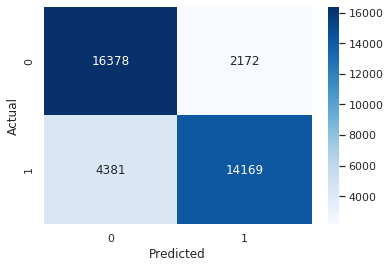

In [22]:
rfc = RandomForestClassifier(n_estimators = 150,
                            max_depth=100, 
                            max_features = 'sqrt',
                            min_samples_leaf=3,
                            min_samples_split=10, 
                            n_jobs=-1,
                            random_state=RSEED, 
                            oob_score = True
                           ) 


# Fit on training data
rfc.fit(X_train, y_train)

y_pred_rfc = rfc.predict(X_test)


#### --- OUTPUT ----  ####
show_all_results(y_test, y_pred_rfc)

### 8.10.1 Feature Importance Random Forest

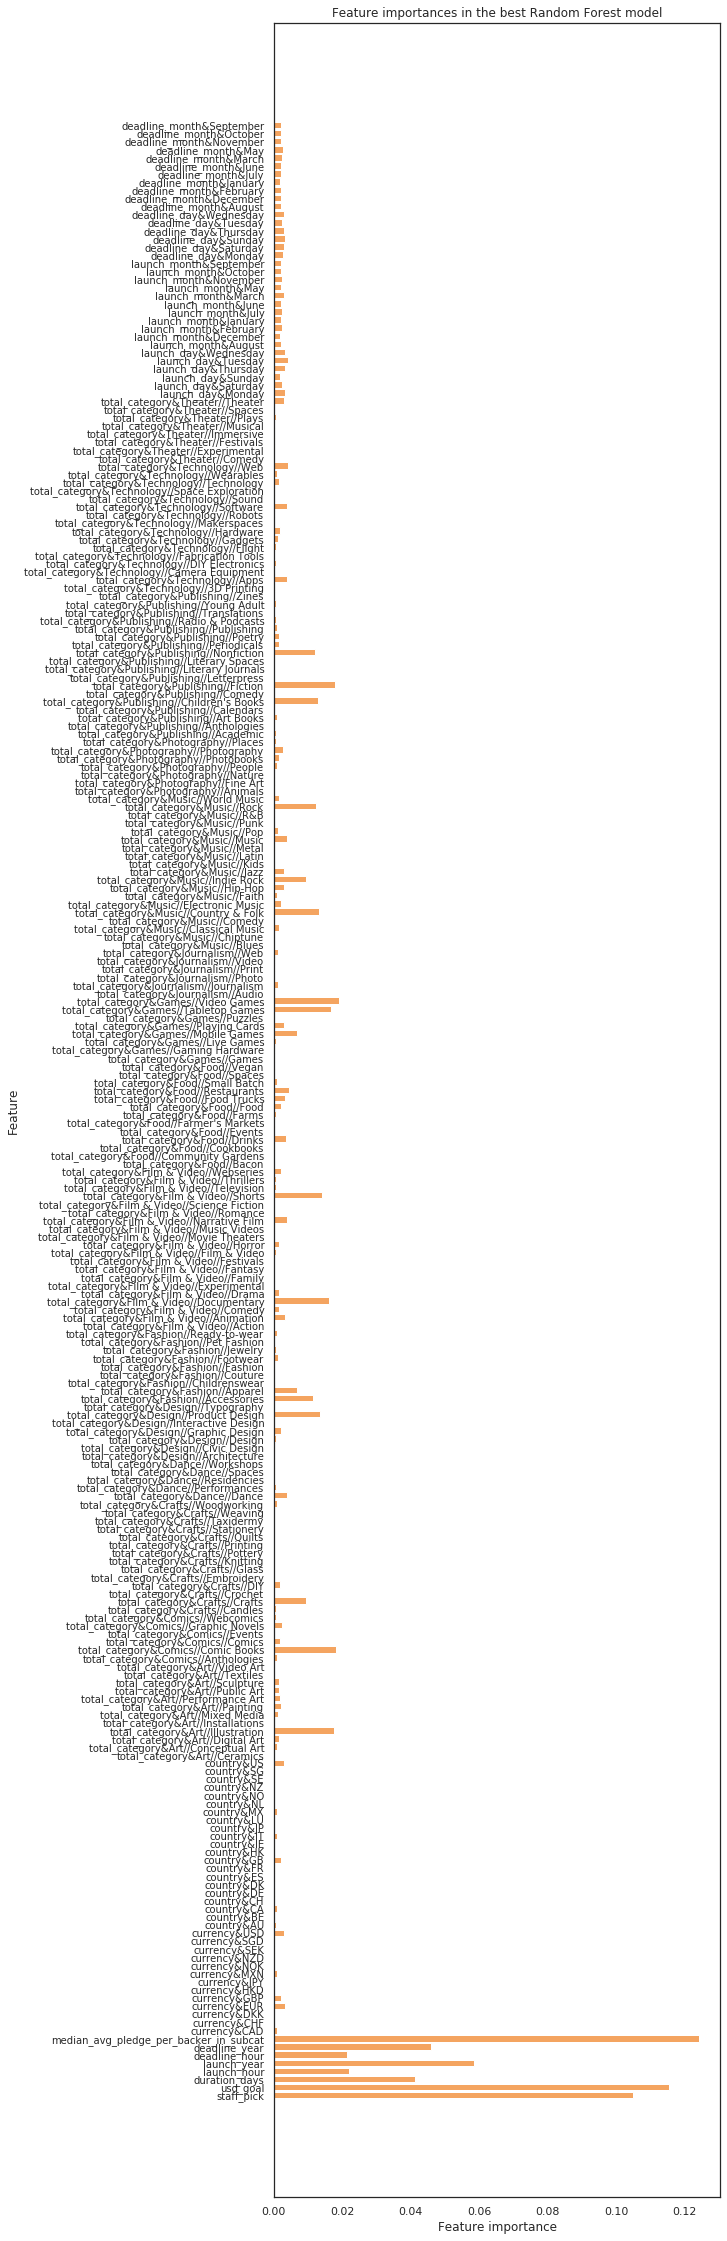

In [23]:
### Feature Importance (incl. Dummies) Vertical, readable, for investigation 
n_features = X_train.shape[1]
plt.figure(figsize=(8,40))
plt.barh(range(n_features), rfc.feature_importances_, align='center', color='sandybrown') 
plt.yticks(np.arange(n_features), X_train.columns.values, fontsize=10) 
plt.title("Feature importances in the best Random Forest model")
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.savefig('figures/FeatureImportance_All_name_RandomForest.png', transparent=True)
plt.show()

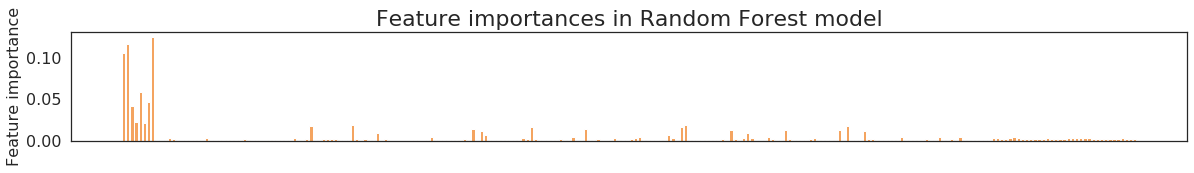

In [24]:
#### Feature Importance (incl. Dummies) Horizontal, only for visualisation of distribution
n_features = X_train.shape[1]
plt.figure(figsize=(20,2))
plt.bar(range(n_features), rfc.feature_importances_, align='center', color='sandybrown') 
plt.title("Feature importances in Random Forest model", fontsize=22)
plt.ylabel("Feature importance", fontsize=16)
plt.yticks(fontsize=16)

plt.xticks([])
plt.xlabel('')
plt.savefig('figures/FeatureImportance_All_presentation_RandomForest.png', transparent=True)
plt.show()

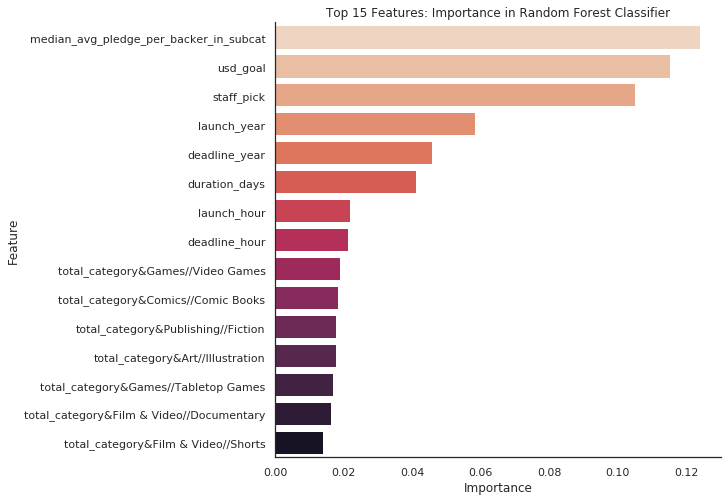

In [24]:
#### Top X Dummie-Features 
results = pd.DataFrame(list(X_train), rfc.feature_importances_).reset_index()
results.columns = ['Importance', 'Feature']
results = results.sort_values(by='Importance', ascending=False).head(15)

f, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x=results.Importance, y=results.Feature, palette='rocket_r')
ax.set_title("Top 15 Features: Importance in Random Forest Classifier")
sns.despine()
plt.savefig('figures/FeatureImportance_Top15_RandomForest.png', transparent=True)
plt.show()

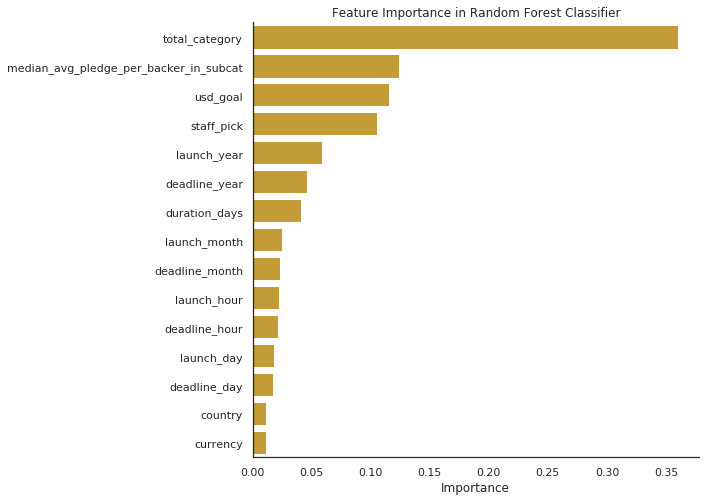

In [25]:
### Importance Main Features
results = pd.DataFrame(list(X_train), rfc.feature_importances_).reset_index()
results.columns = ['Importance', 'Dummie_Feature']
results = results.sort_values(by='Importance', ascending=False)

prefix_sep='&'
results['main_feature'] = results['Dummie_Feature'].apply(lambda x: x.split(prefix_sep)[0].strip())

results = results.groupby('main_feature').sum()
results['Feature'] = results.index
results = results.sort_values(by='Importance', ascending=False)

f, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x=results.Importance, y=results.Feature, color='goldenrod')
ax.set_title("Feature Importance in Random Forest Classifier")
sns.despine()
plt.ylabel('')
plt.savefig('figures/FeatureImportance_Main_RandomForest.png', transparent=True, bbox_inches='tight')
plt.show()

### 8.10.2 Random Forrest using RandomSearch

In [26]:
rfc = RandomForestClassifier(random_state=RSEED, 
                            n_jobs=-1, verbose = 0)
param_grid = {
    'n_estimators': [10, 200, 150], #number of trees in the foreset
    'max_depth': [3, 15, 100], #max number of levels in each decision tree
    'max_features': ['auto', 'sqrt'], #considered for splitting a node
    'min_samples_leaf': [3, 4, 5], # min number of data points placed in a node before the node is split
    'min_samples_split': [8, 10, 12], #min number of data points allowed in a leaf node
    'bootstrap': [True, False] # method for sampling data points (with or without replacement
            }

# Create the random search model
rs_rfc = RandomizedSearchCV(rfc, #model to evaluate on
                    param_grid, 
                    n_jobs = -1, 
                    n_iter = 1, #number of random tries in the RandomSearchGrid
                    scoring = scoring, cv = 5, 
                    verbose = 0, random_state=RSEED)

#fitting the model
rs_rfc.fit(X_train, y_train)

#settings regarding best estimator 
print(rs_rfc.best_estimator_)
print(rs_rfc.best_params_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
{'n_estimators': 10, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 15, 'bootstrap': True}


              precision    recall  f1-score   support

           0       0.76      0.87      0.81     18550
           1       0.85      0.72      0.78     18550

    accuracy                           0.80     37100
   macro avg       0.81      0.80      0.80     37100
weighted avg       0.81      0.80      0.80     37100
 

f1_score:         0.781
accuracy_score:   0.798
precision_score:  0.852
recall_score:     0.722
roc_auc_score:    0.798


MAE:              0.202
MSE:              0.202
RMSE:             0.449
R2-Score:         0.192




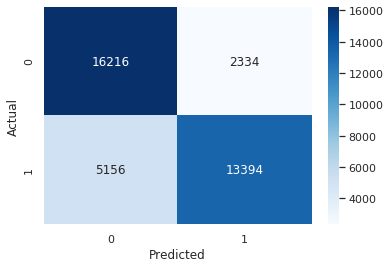

In [27]:
#using the best estimator to predict at X_test
best_rs_rfc = rs_rfc.best_estimator_
best_rs_rfc_predictions = best_rs_rfc.predict(X_test)
show_all_results(y_test,best_rs_rfc_predictions)

## 8.11 Logistic Regression

              precision    recall  f1-score   support

           0       0.66      0.63      0.64     18550
           1       0.64      0.67      0.66     18550

    accuracy                           0.65     37100
   macro avg       0.65      0.65      0.65     37100
weighted avg       0.65      0.65      0.65     37100
 

f1_score:         0.656
accuracy_score:   0.649
precision_score:  0.643
recall_score:     0.671
roc_auc_score:    0.649


MAE:              0.351
MSE:              0.351
RMSE:             0.593
R2-Score:         -0.404




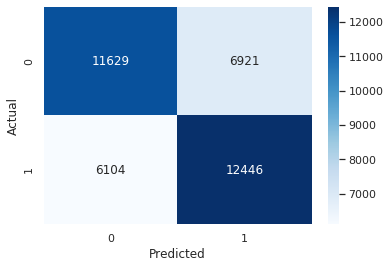

In [28]:
# Create the model
lr = LogisticRegression()

# Fit on training data
lr.fit(X_train, y_train)

# Make the predictions for X_test
y_pred_lr = lr.predict(X_test)

#### --- OUTPUT ----  ####
show_all_results(y_test,y_pred_lr)

## 8.12 XGBoost

              precision    recall  f1-score   support

           0       0.77      0.85      0.81     18550
           1       0.83      0.75      0.79     18550

    accuracy                           0.80     37100
   macro avg       0.80      0.80      0.80     37100
weighted avg       0.80      0.80      0.80     37100
 

f1_score:         0.787
accuracy_score:   0.798
precision_score:  0.831
recall_score:     0.748
roc_auc_score:    0.798


MAE:              0.202
MSE:              0.202
RMSE:             0.449
R2-Score:         0.192




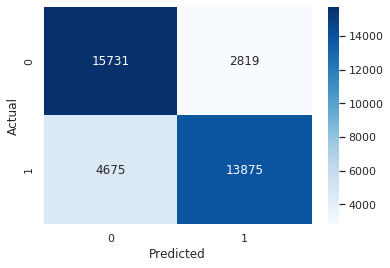

In [29]:
# Create the model
xgb = XGBClassifier()

# Fit on training data
xgb.fit(X_train, y_train)

# Make the predictions for X_test
y_pred_xgb = xgb.predict(X_test)

#### --- OUTPUT ----  ####
show_all_results(y_test,y_pred_xgb)

## 8.13 SVM

              precision    recall  f1-score   support

           0       0.86      0.12      0.21       750
           1       0.53      0.98      0.69       750

    accuracy                           0.55      1500
   macro avg       0.70      0.55      0.45      1500
weighted avg       0.70      0.55      0.45      1500
 

f1_score:         0.686
accuracy_score:   0.55
precision_score:  0.527
recall_score:     0.981
roc_auc_score:    0.55


MAE:              0.45
MSE:              0.45
RMSE:             0.671
R2-Score:         -0.8




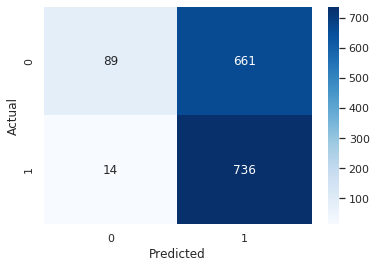

In [30]:
# Create the model
svc = SVC(kernel='rbf') #, C=2000)

# Fit on training data
svc.fit(X_train_r, y_train_r)

# Make the predictions for X_test
y_pred_svc_r = svc.predict(X_test_r)

#### --- OUTPUT ----  ####
show_all_results(y_test_r,y_pred_svc_r)

# 9. Conclusion

The Random Forrest model performes well for the given task with an f1-score of 0.8. As for the features: The category has the greatest influence on the success of a project. As part of the EDA, the median_avg_pledge_per_backer_in_subcat feature is designed. This feature gives an understanding of how much money the average backer in an sub category is willing to back a project. This has great influence on the success rate of a project.

# 10. Data Visualization
Communicate the findings with key stakeholders using plots and interactive visualizations

- Feature Impotance for Random Forest has been visualized in 8.10.1

# 11. Future Work

- Feature Engneering: **Average USD-Pledge per Subcategory** to evaluate better supported subcategories. 
- **ROC Curve**s are another way to illustrate the performance of a specific model. Compared to the F1-Score, ROC Curves contain more information and, hence, generate a deeper understanding of the model's performance. They are especially great for investigating and comparing different models.  Besides, ROC curves are a great tool for communicating results. Hence, in future work, ROC curves should generate a deeper understanding of the model's performance. 
- The used **confusion matrix** fulfills its purpose: comparing the predicted and actual successes and failures. The color-coding is a great addition as it shows the severity of various values at a glance. Nevertheless, percentage values and labeling would be a great addition and is part of future work. 
- Aiming for the stars: The **blurb** (a string description) and the **photo** (mostly different versions of the main image) have been droped in the current analysis earlie on. Splitting the blurb into its fragments could potentially surface a corrolation between success and metaphorical, postive words. In addition, Analysing the images, e.g., for items or for color palets, could bring great insights and be a very steep but rewarding learning curve. 